#**AI in Industry**

**Author**: Jyoti Yadav

**Date**: March 2022

**Email**: jyoti.yadav@studio.unibo.it

##Preliminary Steps

In [40]:
!pip install openml

     |████████████████████████████████| 11.3 MB 4.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dfencoder 0.0.38 requires pandas<1.0.0, but you have pandas 1.3.5 which is incompatible.


In [41]:
!pip install dfencoder

  Using cached pandas-0.25.3-cp37-cp37m-manylinux1_x86_64.whl (10.4 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires pandas>=1.0, but you have pandas 0.25.3 which is incompatible.
openml 0.12.2 requires pandas>=1.0.0, but you have pandas 0.25.3 which is incompatible.
google-colab 1.0.0 requires pandas>=1.1.0; python_version >= "3.0", but you have pandas 0.25.3 which is incompatible.
fbprophet 0.7.1 requires pandas>=1.0.4, but you have pandas 0.25.3 which is incompatible.


In [42]:
!pip install tensorflow-addons

In [43]:
# Important libraries for the model building

import sys 
import gzip
import openml
import os, shutil 
import pandas as pd
import numpy as np
# import EncoderDataFrame 
import seaborn as sns
from pathlib import Path
from urllib import request
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import OneClassSVM
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Dense,Dropout
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.covariance import EllipticEnvelope
from dfencoder import EncoderDataFrame
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc,roc_auc_score
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation


from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

LABELS = ["Normal","Anomly"]

# For the reproducibility of the results
random_state=2022

it is necessary, to clean all the data that are in the DATASETS directory and wipe out all the subdirectories.

In [44]:
# folder = os.getcwd()

# print("Current work directory: " + str(folder))
# dataset_folder = os.path.join(os.getcwd(), "Datasets")
# if not os.path.exists(dataset_folder):
#     os.makedirs(dataset_folder)
# for filename in os.listdir(dataset_folder):
#     file_path = os.path.join(dataset_folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))
# print("Cleaned")

##Dataset Download

In [45]:
# # Config
# print("Current work directory: {}".format(os.getcwd()))
# dataset_folder = os.path.join(os.getcwd(), "Datasets")

# if not os.path.exists(dataset_folder):
#     os.makedirs(dataset_folder)

# url = "https://github.com/jyotiyadav94/Ai-in-industry/raw/main/new_data/r205n13.gzip"


# dataset_path = os.path.join(dataset_folder, "r205n12.gzip")

# print(dataset_path)

# def download_dataset(download_path: str, url: str):
#     if not os.path.exists(download_path):
#         print("Downloading dataset...")
#         request.urlretrieve(url, download_path)
#         print("Download complete!")


# def extract_dataset(download_path: str, extract_path: str):
#     data = pd.read_parquet(dataset_path)
#     print("Extraction completed!")
#     return data

# # Download
# download_dataset(dataset_path, url)

# #Extraction
# df=extract_dataset(dataset_path, dataset_folder)

##Working with multiple files (r20 files)

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
#In order to work with some of the files of the dataset please load the dataset to your directory and 
#I worked with r205n12.gzip,r205n13.gzip,r205n14.gzip

data_dir = Path('/content/drive/MyDrive/AI in industry/new data')
full_df = pd.concat(pd.read_parquet(parquet_file)for parquet_file in data_dir.glob('*.gzip'))
# full_df.to_csv('dataset.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [48]:
full_df

,New_label,avg:ambient,avg:boottime,avg:bytes_in,avg:bytes_out,avg:cpu_aidle,avg:cpu_idle,avg:cpu_nice,avg:cpu_num,avg:cpu_speed,...,var:ps0_input_voltag,var:ps0_output_curre,var:ps0_output_volta,var:ps1_input_power,var:ps1_input_voltag,var:ps1_output_curre,var:ps1_output_volta,var:swap_free,var:swap_total,var:total_power
index,,,,,,,,,,,,,,,,,,,,,
13218,2,23.493333,1.594920e+09,13285.9225,27299.387500,99.233333,100.0,0,128,3800,...,0.495238,1.638095,0.000000,12.380952,0.000000,1.952381,0.000000,0.0,0.0,106.666667
13221,2,25.573333,1.594920e+09,10630.4300,6394.560000,99.833333,100.0,0,128,3800,...,0.266667,1.495238,0.000000,0.000000,0.685714,1.571429,0.000000,0.0,0.0,106.666667
13278,0,21.569231,1.594920e+09,6599.3800,6403.430000,100.000000,100.0,0,128,3800,...,0.307692,0.692308,0.000000,16.666667,1.025641,0.743590,0.000000,0.0,0.0,76.923077
13281,0,21.600000,1.594920e+09,5378.9600,6442.330000,100.000000,100.0,0,128,3800,...,0.685714,2.552381,0.000000,12.380952,0.000000,2.142857,0.000000,0.0,0.0,0.000000
13284,0,21.280000,1.594920e+09,12573.3600,7054.396667,100.000000,100.0,0,128,3800,...,0.000000,1.600000,0.000000,12.380952,0.000000,1.666667,0.000000,0.0,0.0,26.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96180,0,25.400000,1.615891e+09,11174.0000,10293.460000,99.900000,100.0,0,128,3800,...,0.952381,0.209524,0.010667,20.952381,0.000000,0.314286,0.004952,0.0,0.0,0.000000
96183,0,25.413333,1.615891e+09,11201.2200,10410.890000,99.900000,100.0,0,128,3800,...,0.266667,0.266667,0.002571,12.380952,0.000000,0.000000,0.000000,0.0,0.0,26.666667
96186,0,25.400000,1.615891e+09,11407.8400,10224.000000,99.900000,100.0,0,128,3800,...,0.000000,0.257143,0.001714,42.857143,0.000000,0.171429,0.000000,0.0,0.0,49.523810


In [49]:
full_df.columns

Index(['New_label', 'avg:ambient', 'avg:boottime', 'avg:bytes_in',
       'avg:bytes_out', 'avg:cpu_aidle', 'avg:cpu_idle', 'avg:cpu_nice',
       'avg:cpu_num', 'avg:cpu_speed',
       ...
       'var:ps0_input_voltag', 'var:ps0_output_curre', 'var:ps0_output_volta',
       'var:ps1_input_power', 'var:ps1_input_voltag', 'var:ps1_output_curre',
       'var:ps1_output_volta', 'var:swap_free', 'var:swap_total',
       'var:total_power'],
      dtype='object', length=503)

## Data Analysis

In [50]:
full_df.isnull().values.any()

True

In [51]:
#finding the total missing values

missing_values = full_df.isnull().sum()
missing_per = (missing_values/full_df.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
New_label,0,0.0
avg:ambient,0,0.0
avg:boottime,0,0.0
avg:bytes_in,0,0.0
avg:bytes_out,0,0.0
...,...,...
var:ps1_output_curre,0,0.0
var:ps1_output_volta,0,0.0
var:swap_free,0,0.0
var:swap_total,0,0.0


In [52]:
full_df

,New_label,avg:ambient,avg:boottime,avg:bytes_in,avg:bytes_out,avg:cpu_aidle,avg:cpu_idle,avg:cpu_nice,avg:cpu_num,avg:cpu_speed,...,var:ps0_input_voltag,var:ps0_output_curre,var:ps0_output_volta,var:ps1_input_power,var:ps1_input_voltag,var:ps1_output_curre,var:ps1_output_volta,var:swap_free,var:swap_total,var:total_power
index,,,,,,,,,,,,,,,,,,,,,
13218,2,23.493333,1.594920e+09,13285.9225,27299.387500,99.233333,100.0,0,128,3800,...,0.495238,1.638095,0.000000,12.380952,0.000000,1.952381,0.000000,0.0,0.0,106.666667
13221,2,25.573333,1.594920e+09,10630.4300,6394.560000,99.833333,100.0,0,128,3800,...,0.266667,1.495238,0.000000,0.000000,0.685714,1.571429,0.000000,0.0,0.0,106.666667
13278,0,21.569231,1.594920e+09,6599.3800,6403.430000,100.000000,100.0,0,128,3800,...,0.307692,0.692308,0.000000,16.666667,1.025641,0.743590,0.000000,0.0,0.0,76.923077
13281,0,21.600000,1.594920e+09,5378.9600,6442.330000,100.000000,100.0,0,128,3800,...,0.685714,2.552381,0.000000,12.380952,0.000000,2.142857,0.000000,0.0,0.0,0.000000
13284,0,21.280000,1.594920e+09,12573.3600,7054.396667,100.000000,100.0,0,128,3800,...,0.000000,1.600000,0.000000,12.380952,0.000000,1.666667,0.000000,0.0,0.0,26.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96180,0,25.400000,1.615891e+09,11174.0000,10293.460000,99.900000,100.0,0,128,3800,...,0.952381,0.209524,0.010667,20.952381,0.000000,0.314286,0.004952,0.0,0.0,0.000000
96183,0,25.413333,1.615891e+09,11201.2200,10410.890000,99.900000,100.0,0,128,3800,...,0.266667,0.266667,0.002571,12.380952,0.000000,0.000000,0.000000,0.0,0.0,26.666667
96186,0,25.400000,1.615891e+09,11407.8400,10224.000000,99.900000,100.0,0,128,3800,...,0.000000,0.257143,0.001714,42.857143,0.000000,0.171429,0.000000,0.0,0.0,49.523810


In [53]:
data=full_df

In [54]:
# drop the columns which contain at least one NaN value

data = full_df.dropna(axis='columns')

In [55]:
#finding the total missing values in the column

missing_values = data.isnull().sum()
missing_per = (missing_values/data.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
New_label,0,0.0
avg:ambient,0,0.0
avg:boottime,0,0.0
avg:bytes_in,0,0.0
avg:bytes_out,0,0.0
...,...,...
var:ps1_output_curre,0,0.0
var:ps1_output_volta,0,0.0
var:swap_free,0,0.0
var:swap_total,0,0.0


In [56]:
df=data
print(df.shape)

#check the total missing rows
print(df.isnull().any(axis=1).sum())

#drop the rows which contain at least NaN values
df.dropna( axis=0,  how='any',inplace=True)

#check if any NaNs after removing
print(df.isnull().values.any())
df.shape

(36547, 407)
0
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(36547, 407)

In [57]:
#finding the unique number of labels in the dataset

print("No. of unique labels ", len(df['New_label'].unique()))
print("Label values ",df.New_label.unique())

No. of unique labels  2
Label values  [2 0]


In [58]:
#finding the count & percentage for each label 

data = df['New_label'].value_counts().to_frame().reset_index()
data['percent'] = data["New_label"].apply(lambda x : round(100*float(x) / len(df), 2))
data = data.rename(columns = {"index" : "Target", "New_label" : "Count"})
data

,Target,Count,percent
0,0,35231,96.4
1,2,1316,3.6


## Imabalanced dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


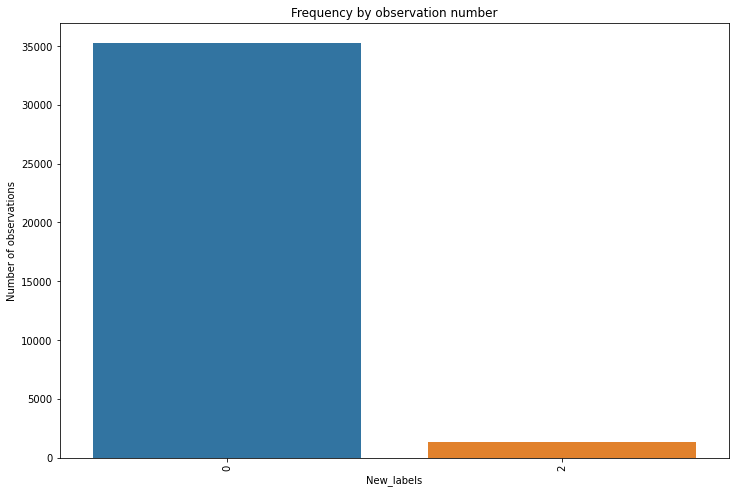

In [59]:
#visualizing both the New_label classes

countSet = df['New_label'].value_counts()
countSet

plt.figure(figsize=(12,8))
sns.barplot(countSet.index,countSet.values,)
plt.ylabel('Number of observations')
plt.xlabel('New_labels')
plt.title('Frequency by observation number')
plt.xticks(rotation='vertical')
plt.show()

In [60]:
Normal = df[df['New_label']==0]
Anomly = df[df['New_label']==2]
outlier_fraction = len(Anomly)/float(len(Normal))
print(outlier_fraction)

0.03735346711702762


In [61]:
#drop the label and timestamp as they are not required

df.drop('label', axis=1, inplace=True)
df.drop('timestamp', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [62]:
df1=df

In [63]:
df.shape

(36547, 405)

##Train Test Split

In [64]:
#train test split with 80% training and 20% testing

X_train, X_test = train_test_split(df,test_size = 0.2,random_state=2022)

In [65]:
#training the model with only Normal dataset so keeping only the normal data during the training and removing anomolies from the training dataset

X_train=X_train[X_train.New_label==0]
X_train = X_train.drop(['New_label'], axis=1) 
y_test = X_test['New_label']
X_test = X_test.drop(['New_label'], axis=1)

In [66]:
X_test

,avg:ambient,avg:boottime,avg:bytes_in,avg:bytes_out,avg:cpu_aidle,avg:cpu_idle,avg:cpu_nice,avg:cpu_num,avg:cpu_speed,avg:cpu_steal,...,var:ps0_input_voltag,var:ps0_output_curre,var:ps0_output_volta,var:ps1_input_power,var:ps1_input_voltag,var:ps1_output_curre,var:ps1_output_volta,var:swap_free,var:swap_total,var:total_power
index,,,,,,,,,,,,,,,,,,,,,
77667,24.573333,1.602593e+09,9701.215,10447.145,100.0,100.000000,0,128,3800,0,...,0.266667,2.971429,0.000000,6.666667,0.266667,2.352381,0.000000,0.000000,0.0,0.000000
61686,24.400000,1.602593e+09,6299.490,6431.520,100.0,100.000000,0,128,3800,0,...,0.000000,2.809524,0.000000,6.666667,0.000000,2.209524,0.000000,0.000000,0.0,0.000000
78582,23.640000,1.602593e+09,6104.600,6514.640,100.0,100.000000,0,128,3800,0,...,1.066667,2.571429,0.000000,23.809524,0.495238,1.600000,0.000000,0.000000,0.0,0.000000
78696,23.600000,1.602593e+09,13206.030,13300.080,100.0,99.975000,0,128,3800,0,...,0.000000,3.600000,0.000000,23.809524,0.000000,2.523810,0.000000,0.000000,0.0,0.000000
92568,24.000000,1.615891e+09,5634.460,6093.240,99.9,100.000000,0,128,3800,0,...,0.685714,0.980952,0.021238,83.809524,0.000000,1.066667,0.010286,0.000000,0.0,83.809524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,20.866667,1.588527e+09,40464.570,7505.520,99.9,100.000000,0,128,3800,0,...,1.066667,1.714286,0.000000,23.809524,1.028571,2.066667,0.000000,0.000000,0.0,0.000000
64953,24.773333,1.602593e+09,6800.770,7055.650,100.0,100.000000,0,128,3800,0,...,0.000000,5.495238,0.000000,6.666667,0.000000,3.409524,0.000000,0.000000,0.0,0.000000
48534,23.400000,1.602593e+09,7954.060,9390.840,100.0,99.966667,0,128,3800,0,...,0.266667,2.780952,0.000000,0.000000,0.000000,2.457143,0.000000,682.666667,0.0,0.000000


##Minmax Scaling

In [67]:
#performing minmax scaling on dataframe X_train,X_test & y_test

normalizer = preprocessing.MinMaxScaler(feature_range=(0, 1))
normalized_train_X = pd.DataFrame(normalizer.fit_transform(X_train),  columns = X_train.columns)
normalized_test_X = pd.DataFrame(normalizer.fit_transform(X_test),  columns = X_test.columns)
normalized_test_y=normalizer.fit_transform(y_test.values.reshape(-1,1))

#converting the 2d array to 1d flattened array
y_test_=normalized_test_y.ravel()

In [68]:
normalized_test_y.shape

(7310, 1)

In [69]:
normalized_test_X.shape

(7310, 404)

## Semi Supervised Algorithm: Autoencoder

In [70]:
#providing the parameters for the autoencoder model

input_dim=normalized_train_X.shape[1]
print('input_dim',input_dim)
encoding_dim=230
print('encoding_dim',encoding_dim)
hidden_dim_1 = int(encoding_dim / 2)
print('hidden_dim_1',hidden_dim_1)
hidden_dim_2=60
print('hidden_dim_2',hidden_dim_2)
epoch=100
batch_size=32
learning_rate = 1e-5

input_dim 404
encoding_dim 230
hidden_dim_1 115
hidden_dim_2 60


In [71]:
#Implementation of autoencoder model

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l2(learning_rate))(input_layer)
encoder=Dropout(0.2)(encoder)
encoder =Dense(hidden_dim_1, activation='relu')(encoder)
# encoder=Dropout(0.2)(encoder)
encoder = Dense(hidden_dim_2, activation="tanh")(encoder)


decoder = Dense(hidden_dim_1, activation='relu')(encoder)
decoder=Dropout(0.2)(decoder)
decoder = Dense(encoding_dim, activation='tanh')(decoder)
# decoder=Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 404)]             0         
                                                                 
 dense_6 (Dense)             (None, 230)               93150     
                                                                 
 dropout_2 (Dropout)         (None, 230)               0         
                                                                 
 dense_7 (Dense)             (None, 115)               26565     
                                                                 
 dense_8 (Dense)             (None, 60)                6960      
                                                                 
 dense_9 (Dense)             (None, 115)               7015      
                                                                 
 dropout_3 (Dropout)         (None, 115)               0   

In [72]:
import time

#Early stopping
# early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=10,verbose=1, mode='min',restore_best_weights=True)
autoencoder.compile(loss='mean_squared_error', optimizer='SGD')
start_time = time.time()
history = autoencoder.fit(normalized_train_X, normalized_train_X, epochs=epoch, batch_size=batch_size,shuffle=True,validation_data=(normalized_test_X, normalized_test_X),verbose=1).history
end_time = time.time()
print('Time Taken',end_time-start_time)

Epoch 1/100
881/881 [==============================] - 5s 5ms/step - loss: 0.1203 - val_loss: 0.0999
Epoch 2/100
881/881 [==============================] - 5s 6ms/step - loss: 0.0639 - val_loss: 0.0349
Epoch 3/100
881/881 [==============================] - 5s 6ms/step - loss: 0.0292 - val_loss: 0.0183
Epoch 4/100
881/881 [==============================] - 6s 6ms/step - loss: 0.0209 - val_loss: 0.0153
Epoch 5/100
881/881 [==============================] - 6s 7ms/step - loss: 0.0181 - val_loss: 0.0144
Epoch 6/100
881/881 [==============================] - 5s 6ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 7/100
881/881 [==============================] - 5s 6ms/step - loss: 0.0155 - val_loss: 0.0136
Epoch 8/100
881/881 [==============================] - 5s 6ms/step - loss: 0.0147 - val_loss: 0.0134
Epoch 9/100
881/881 [==============================] - 5s 6ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 10/100
881/881 [==============================] - 5s 6ms/step - loss: 0.0136 - val_lo

In [73]:
#save the weights of autoencoder

autoencoder.save_weights('autoencoder.h5')

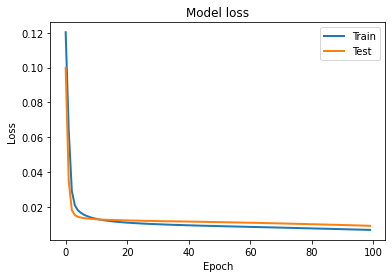

In [74]:
#plot the loss and validation loss of the model

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

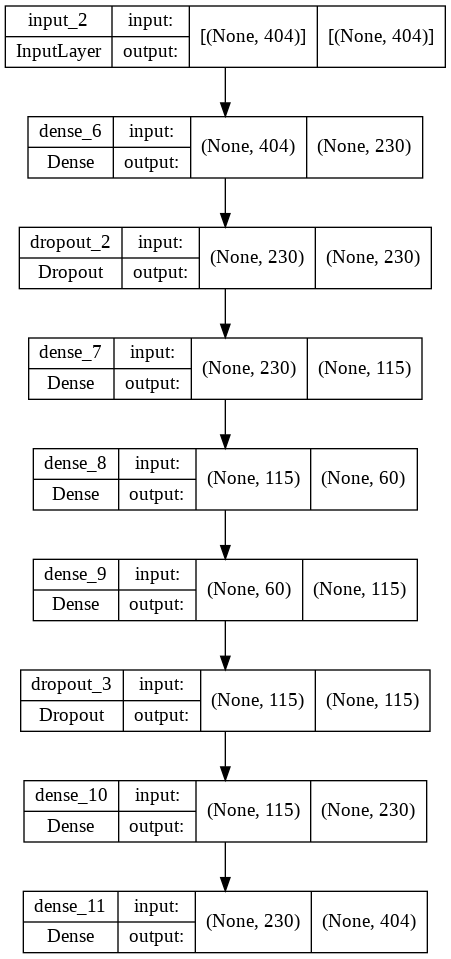

In [75]:
# plot the autoencoder

plot_model(autoencoder, 'autoencoder.png', show_shapes=True, show_layer_names=True)

## Reconstruction error check

In [76]:
#Checking the Reconstruction error loss

test_x_predictions=autoencoder.predict(normalized_test_X)
mse=np.mean(np.power(normalized_test_X-test_x_predictions,2),axis=1)

error=pd.DataFrame({'Reconstruction_error':mse,'True_class':y_test_})
error.head()

,Reconstruction_error,True_class
0,0.005940,0.0
1,0.005398,0.0
2,0.006178,0.0
3,0.006691,0.0
4,0.017326,0.0


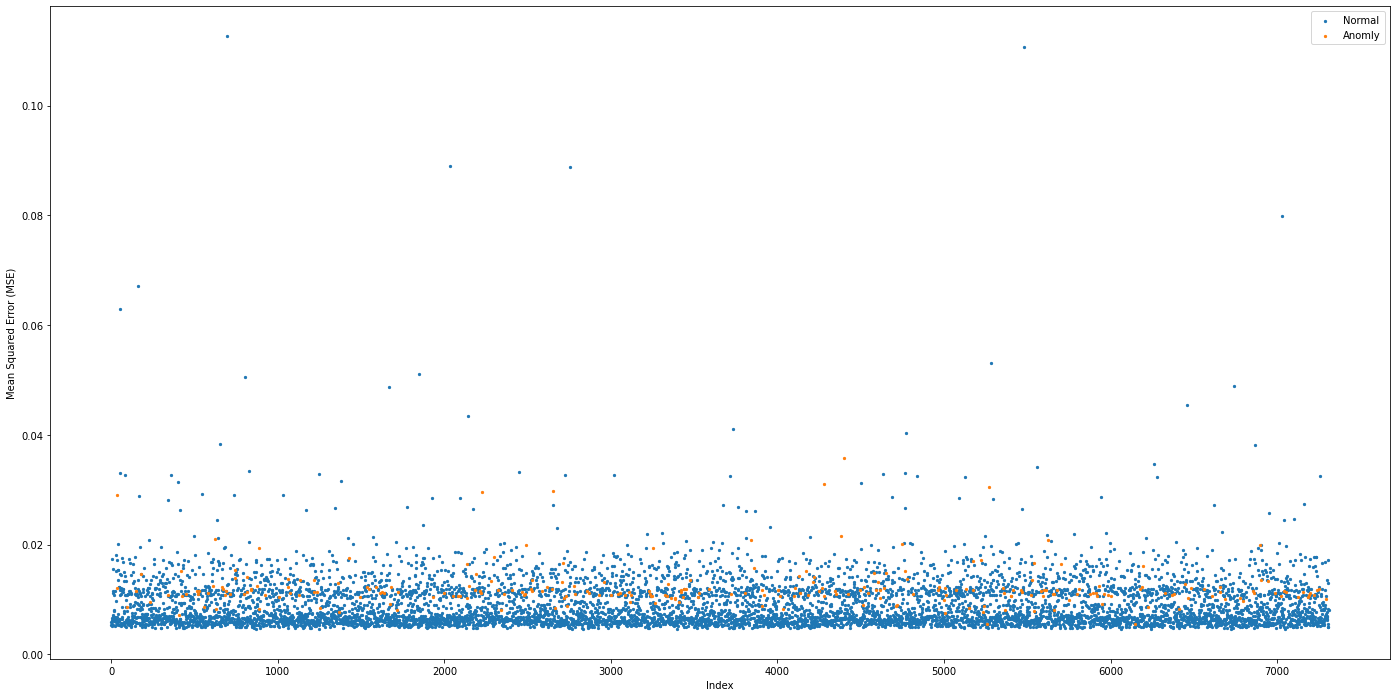

In [77]:
#plot of the distribution of the anomolies and the normal classes

plt.figure(figsize = (24, 12))
plt.scatter(error.index[error['True_class']==0],error[error['True_class']==0]['Reconstruction_error'],s=5,label='Normal')
plt.scatter(error.index[error['True_class']==1],error[error['True_class']==1]['Reconstruction_error'],s=5,label='Anomly')
plt.xlabel('Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

In [78]:
# Finding the f1_score.

precision,recall,threshold=precision_recall_curve(error.True_class,error.Reconstruction_error)
f1_score=2*precision*recall/(precision+recall)
average_precision=average_precision_score(error.True_class,error.Reconstruction_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [79]:
#choosing the best threshold in order to maximize the F1 score

max_f1=f1_score[f1_score==max(f1_score)]
best_threshold=threshold[f1_score[1: ]==max_f1]
print('best threshold : ',best_threshold)

best threshold :  [0.01013165]


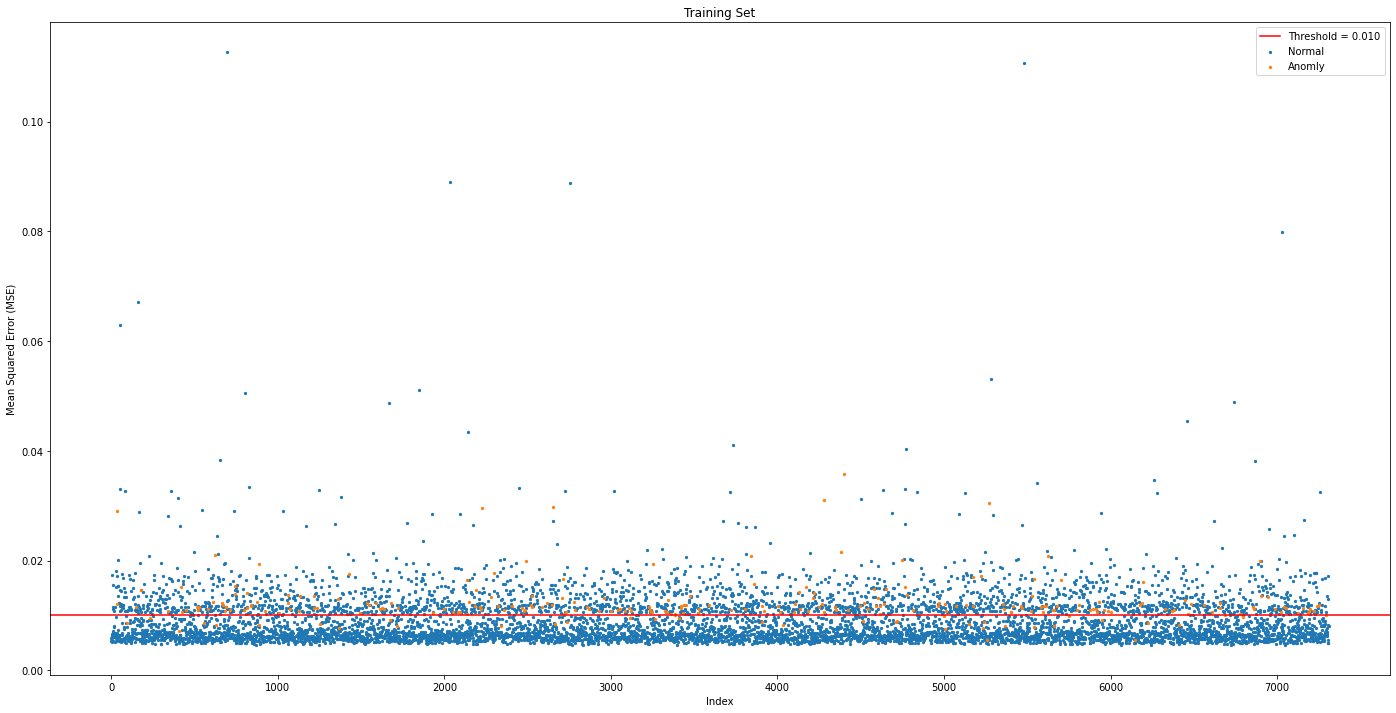

Best threshold = 0.010132


In [80]:
#Best threshold plots

plt.figure(figsize = (24, 12))
plt.scatter(error.index[error['True_class'] == 0], error[error['True_class'] == 0]['Reconstruction_error'], s = 5, label = 'Normal')
plt.scatter(error.index[error['True_class'] == 1], error[error['True_class'] == 1]['Reconstruction_error'], s = 5, label = 'Anomly')
plt.axhline(best_threshold, color = 'red', label = 'Threshold = %0.3f' % (best_threshold))
plt.xlabel('Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Set')
plt.legend()
plt.show()
print('Best threshold = %f' % (best_threshold))

In [81]:
#defining the metrics for the model

def metrics(Y,pred):
  print("Accuracy Score :",accuracy_score(Y,pred))
  print('ROC AUC score :',roc_auc_score(Y, pred))
  recall=recall_score(Y,pred)
  print('recall :',recall)
  precision=precision_score(Y,pred)
  print('precision :',precision)
  f1_Score=2*(recall * precision)/(recall+precision)
  print('f1_score :',f1_Score)
  print("Classification Report :")
  print(classification_report(Y,pred))
  print('\n')
  conf_matrix = confusion_matrix(Y, pred)
  plt.figure(figsize=(10, 10))
  sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap='Blues');
  plt.title("Confusion matrix")
  plt.ylabel('True class')
  plt.xlabel('Predicted class')
  plt.show()

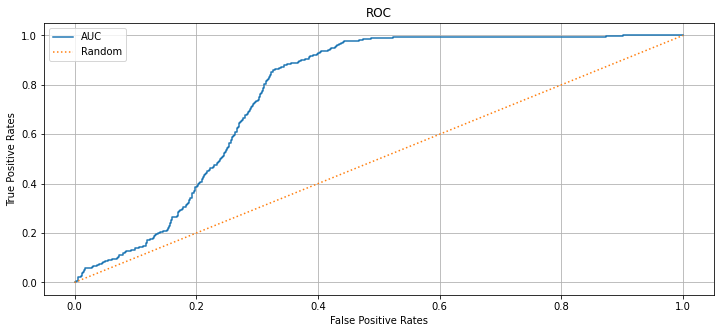

In [82]:
#defining the ROC curve

fpr, tpr, thres = roc_curve(error.True_class, error.Reconstruction_error)
plt.figure(figsize = (12, 5))
plt.plot(fpr, tpr, label = 'AUC') 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("True Positive Rates") 
plt.xlabel("False Positive Rates") 
plt.title('ROC') 
plt.show() 

Accuracy Score : 0.6801641586867305
ROC AUC score : 0.765904133571839
recall : 0.8582375478927203
precision : 0.08871287128712871
f1_score : 0.16080402010050251
Classification Report :
              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      7049
         1.0       0.09      0.86      0.16       261

    accuracy                           0.68      7310
   macro avg       0.54      0.77      0.48      7310
weighted avg       0.96      0.68      0.78      7310





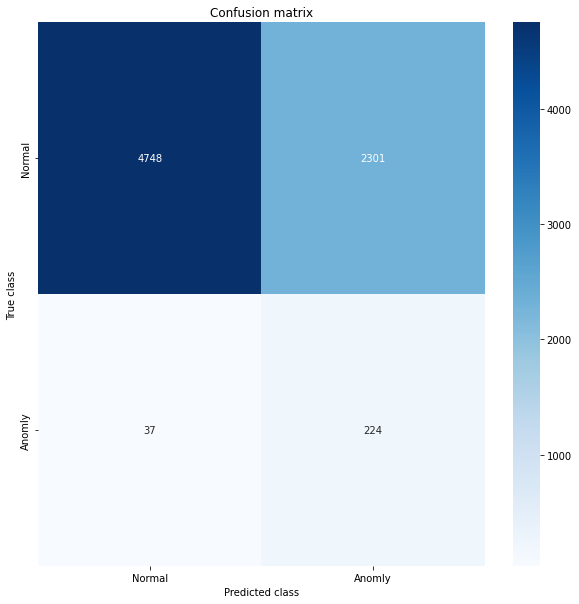

None


In [83]:
# if reconstruction error is greater than threshold it is Anomly 

pred_y = [1 if e > best_threshold  else 0 for e in error.Reconstruction_error.values]
error['pred'] =pred_y
print(metrics(error.True_class,pred_y))

#Unsupervised Algorithm

In [84]:
normalizer = preprocessing.MinMaxScaler(feature_range=(0, 1))
normalized_df = pd.DataFrame(normalizer.fit_transform(df1),  columns = df1.columns)

In [85]:
normalized_df

,New_label,avg:ambient,avg:boottime,avg:bytes_in,avg:bytes_out,avg:cpu_aidle,avg:cpu_idle,avg:cpu_nice,avg:cpu_num,avg:cpu_speed,...,var:ps0_input_voltag,var:ps0_output_curre,var:ps0_output_volta,var:ps1_input_power,var:ps1_input_voltag,var:ps1_output_curre,var:ps1_output_volta,var:swap_free,var:swap_total,var:total_power
0,1.0,0.412959,0.233623,0.011608,0.000997,0.000000,1.0,0.0,0.0,0.0,...,0.108333,0.005969,0.000000,0.000242,0.000000,0.006471,0.000000,0.0,0.0,0.000666
1,1.0,0.534738,0.233623,0.008612,0.000227,0.782609,1.0,0.0,0.0,0.0,...,0.058333,0.005449,0.000000,0.000000,0.150000,0.005209,0.000000,0.0,0.0,0.000666
2,0.0,0.300306,0.233623,0.004064,0.000227,1.000000,1.0,0.0,0.0,0.0,...,0.067308,0.002523,0.000000,0.000326,0.224359,0.002465,0.000000,0.0,0.0,0.000480
3,0.0,0.302108,0.233623,0.002687,0.000228,1.000000,1.0,0.0,0.0,0.0,...,0.150000,0.009301,0.000000,0.000242,0.000000,0.007103,0.000000,0.0,0.0,0.000000
4,0.0,0.283372,0.233623,0.010804,0.000251,1.000000,1.0,0.0,0.0,0.0,...,0.000000,0.005830,0.000000,0.000242,0.000000,0.005524,0.000000,0.0,0.0,0.000166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36542,0.0,0.524590,1.000000,0.009226,0.000370,0.869565,1.0,0.0,0.0,0.0,...,0.208333,0.000763,0.355556,0.000410,0.000000,0.001042,0.000121,0.0,0.0,0.000000
36543,0.0,0.525371,1.000000,0.009256,0.000375,0.869565,1.0,0.0,0.0,0.0,...,0.058333,0.000972,0.085714,0.000242,0.000000,0.000000,0.000000,0.0,0.0,0.000166
36544,0.0,0.524590,1.000000,0.009489,0.000368,0.869565,1.0,0.0,0.0,0.0,...,0.000000,0.000937,0.057143,0.000839,0.000000,0.000568,0.000000,0.0,0.0,0.000309
36545,0.0,0.538642,1.000000,0.009268,0.000368,0.869565,1.0,0.0,0.0,0.0,...,0.000000,0.000625,0.057143,0.000242,0.000000,0.000221,0.000000,0.0,0.0,0.000166


In [86]:
col=normalized_df.columns.tolist()

col=[co for co in col if co not in ['New_label']]
print(col)
target='New_label'

X=normalized_df[col]
Y=normalized_df[target]

print(type(X))

print(X.shape)
print(Y.shape)

['avg:ambient', 'avg:boottime', 'avg:bytes_in', 'avg:bytes_out', 'avg:cpu_aidle', 'avg:cpu_idle', 'avg:cpu_nice', 'avg:cpu_num', 'avg:cpu_speed', 'avg:cpu_steal', 'avg:cpu_system', 'avg:cpu_user', 'avg:cpu_wio', 'avg:dimm0_temp', 'avg:dimm10_temp', 'avg:dimm11_temp', 'avg:dimm12_temp', 'avg:dimm13_temp', 'avg:dimm14_temp', 'avg:dimm15_temp', 'avg:dimm1_temp', 'avg:dimm2_temp', 'avg:dimm3_temp', 'avg:dimm4_temp', 'avg:dimm5_temp', 'avg:dimm6_temp', 'avg:dimm7_temp', 'avg:dimm8_temp', 'avg:dimm9_temp', 'avg:fan0_0', 'avg:fan0_1', 'avg:fan1_0', 'avg:fan1_1', 'avg:fan2_0', 'avg:fan2_1', 'avg:fan3_0', 'avg:fan3_1', 'avg:fan_disk_power', 'avg:gpu0_core_temp', 'avg:gpu0_mem_temp', 'avg:gpu1_core_temp', 'avg:gpu1_mem_temp', 'avg:gpu3_core_temp', 'avg:gpu3_mem_temp', 'avg:gpu4_core_temp', 'avg:gpu4_mem_temp', 'avg:gv100card0', 'avg:gv100card1', 'avg:gv100card3', 'avg:gv100card4', 'avg:load_fifteen', 'avg:load_five', 'avg:load_one', 'avg:mem_buffers', 'avg:mem_cached', 'avg:mem_free', 'avg:mem_s

##Isolation Forest

In [87]:
Isolation_Forest=IsolationForest(n_estimators=100,max_samples=len(X),contamination=outlier_fraction,random_state=2022,verbose=0)
Isolation_Forest.fit(X)
scores_prediction=Isolation_Forest.decision_function(X)
y_pred2=Isolation_Forest.predict(X)
y_pred2[y_pred2==1]=0 #0 for Normal
y_pred2[y_pred2==-1]=1 #1 Anomly

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


Isolation_Forest: 2466
Accuracy Score : 0.9325252414698881
ROC AUC score : 0.5231798398050074
recall : 0.08206686930091185
precision : 0.07906295754026355
f1_score : 0.08053691275167786
Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     35231
         1.0       0.08      0.08      0.08      1316

    accuracy                           0.93     36547
   macro avg       0.52      0.52      0.52     36547
weighted avg       0.93      0.93      0.93     36547





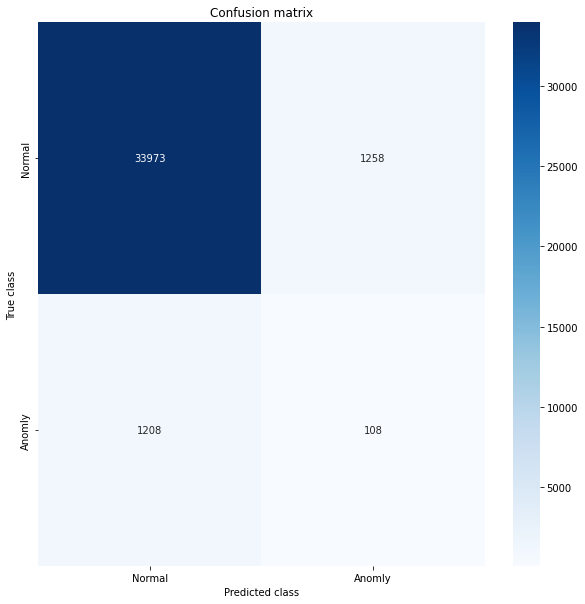

None




In [88]:
n_errors2=(y_pred2!=Y).sum()
print("{}: {}".format('Isolation_Forest',n_errors2))
print(metrics(Y,y_pred2))
print('\n')

##Local Outlier Factor

In [89]:
Local_Outlier_Factor=LocalOutlierFactor(n_neighbors=20,algorithm='auto', leaf_size=30, metric='minkowski',p=2, metric_params=None, contamination=outlier_fraction)
Local_Outlier_Factor.fit(X)
score_prediction=Local_Outlier_Factor.negative_outlier_factor_
y_pred3=Local_Outlier_Factor.fit_predict(X)
y_pred3[y_pred3==1]=0 #0 for Normal
y_pred3[y_pred3==-1]=1 #1 Anomly

In [90]:
# type(y_pred3)
type(normalized_test_y)

numpy.ndarray

Local Outlier Factor: 2480
Accuracy Score : 0.9321421730921827
ROC AUC score : 0.5204209210094833
recall : 0.07674772036474165
precision : 0.0739385065885798
f1_score : 0.07531692766592095
Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     35231
         1.0       0.07      0.08      0.08      1316

    accuracy                           0.93     36547
   macro avg       0.52      0.52      0.52     36547
weighted avg       0.93      0.93      0.93     36547





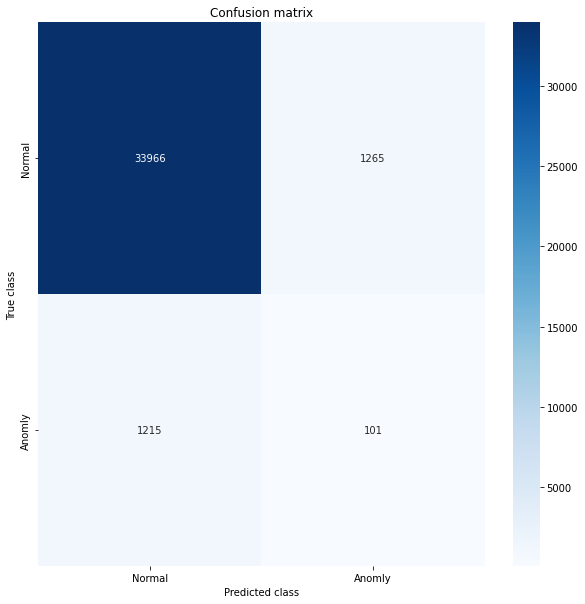

None




In [91]:
n_errors=(y_pred3!=Y).sum()
print("{}: {}".format('Local Outlier Factor',n_errors))
print(metrics(Y,y_pred3))
print('\n')

##One class SVM

In [92]:
One_Class_SVM=OneClassSVM(kernel='rbf',degree=3,gamma=0.1,nu=0.05,max_iter=-1)
One_Class_SVM.fit(X)
y_pred4=One_Class_SVM.predict(X)
y_pred4[y_pred4==1]=0 #0 for Normal
y_pred4[y_pred4==-1]=1 #1 Anomly

One Class SVM: 2907
Accuracy Score : 0.9204585875721674
ROC AUC score : 0.520578618805851
recall : 0.08966565349544073
precision : 0.06458675424192666
f1_score : 0.07508749602290807
Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     35231
         1.0       0.06      0.09      0.08      1316

    accuracy                           0.92     36547
   macro avg       0.52      0.52      0.52     36547
weighted avg       0.93      0.92      0.93     36547





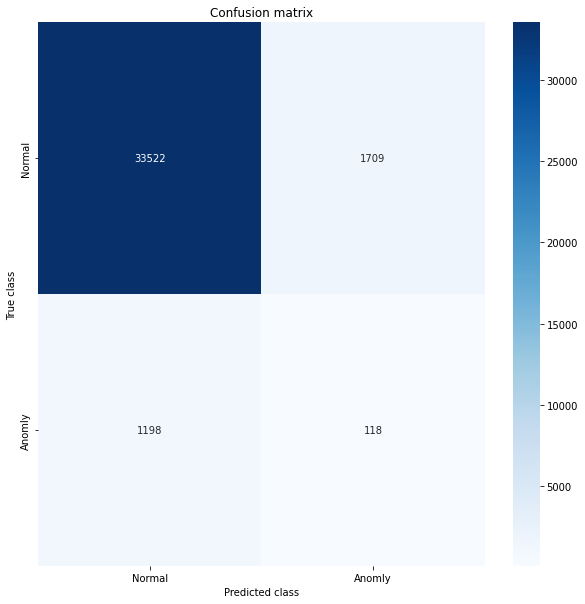

None




In [93]:
n_errors4=(y_pred4!=Y).sum()
print("{}: {}".format('One Class SVM',n_errors4))
print(metrics(Y,y_pred4))
print('\n')

##Minimum Covariance Determinant

In [94]:
minimum_covariant_determinant = EllipticEnvelope(contamination=0.01,random_state=2022)
minimum_covariant_determinant.fit(X)
y_pred5=minimum_covariant_determinant.predict(X)
y_pred5[y_pred5==1]=0 #0 for Normal
y_pred5[y_pred5==-1]=1 #1 Anomly

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


One Class SVM: 1626
Accuracy Score : 0.9555093441322133
ROC AUC score : 0.505841386061719
recall : 0.02127659574468085
precision : 0.07650273224043716
f1_score : 0.03329369797859691
Classification Report :
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     35231
         1.0       0.08      0.02      0.03      1316

    accuracy                           0.96     36547
   macro avg       0.52      0.51      0.51     36547
weighted avg       0.93      0.96      0.94     36547





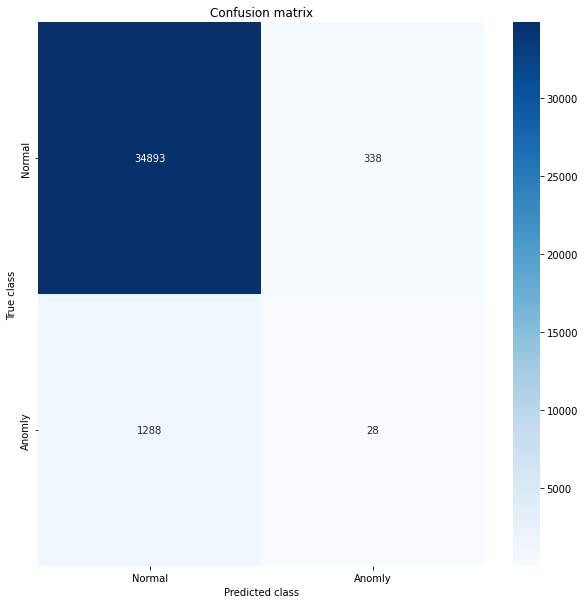

None




In [95]:
n_errors5=(y_pred5!=Y).sum()
print("{}: {}".format('One Class SVM',n_errors5))
print(metrics(Y,y_pred5))
print('\n')

##Self Supervised Contrastive Learning

In [97]:
X = df1.drop("New_label",1)   #Features
y = df1["New_label"]          #Target

In [99]:
X.head()

,avg:ambient,avg:boottime,avg:bytes_in,avg:bytes_out,avg:cpu_aidle,avg:cpu_idle,avg:cpu_nice,avg:cpu_num,avg:cpu_speed,avg:cpu_steal,...,var:ps0_input_voltag,var:ps0_output_curre,var:ps0_output_volta,var:ps1_input_power,var:ps1_input_voltag,var:ps1_output_curre,var:ps1_output_volta,var:swap_free,var:swap_total,var:total_power
index,,,,,,,,,,,,,,,,,,,,,
13218,23.493333,1.594920e+09,13285.9225,27299.387500,99.233333,100.0,0,128,3800,0,...,0.495238,1.638095,0.0,12.380952,0.000000,1.952381,0.0,0.0,0.0,106.666667
13221,25.573333,1.594920e+09,10630.4300,6394.560000,99.833333,100.0,0,128,3800,0,...,0.266667,1.495238,0.0,0.000000,0.685714,1.571429,0.0,0.0,0.0,106.666667
13278,21.569231,1.594920e+09,6599.3800,6403.430000,100.000000,100.0,0,128,3800,0,...,0.307692,0.692308,0.0,16.666667,1.025641,0.743590,0.0,0.0,0.0,76.923077
13281,21.600000,1.594920e+09,5378.9600,6442.330000,100.000000,100.0,0,128,3800,0,...,0.685714,2.552381,0.0,12.380952,0.000000,2.142857,0.0,0.0,0.0,0.000000
13284,21.280000,1.594920e+09,12573.3600,7054.396667,100.000000,100.0,0,128,3800,0,...,0.000000,1.600000,0.0,12.380952,0.000000,1.666667,0.0,0.0,0.0,26.666667


###Data Augumentation

In [100]:
# #data augumentation using swap
# https://towardsdatascience.com/how-to-apply-self-supervision-to-tabular-data-introducing-dfencoder-eec21c4afaef


# df=EncoderDataFrame(X)
# df.swap(likelihood=0.3)
# df

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2022)

In [102]:
input_shape=X_train.shape[-1]
print(input_shape)

404


###encoder model

In [103]:
def create_encoder():
    inputs = Input(shape=input_shape)            # input layer
    encoded = GaussianNoise(0.0025)(inputs)      # Gaussian Additive Noise
    x = Dense(64, activation='relu')(encoded)     # Dense layer
    outputs = Dense(64, activation='softmax')(x) # output layer
    model = Model(inputs, outputs)
    return model

encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 128
hidden_units = 256
projection_units = 128
num_epochs = 200
dropout_rate = 0.5
temperature = 1

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 404)]             0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 404)              0         
 se)                                                             
                                                                 
 dense_12 (Dense)            (None, 64)                25920     
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
Total params: 30,080
Trainable params: 30,080
Non-trainable params: 0
_________________________________________________________________


###Supervised baseline model

In [104]:
#classification model
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(input_shape, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.SGD(learning_rate),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],)
    return model

encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()


#Training the basline classification model
baseline_history  = classifier.fit(x=X_train, y=y_train,validation_split = 0.2, batch_size=batch_size, epochs=num_epochs,shuffle=True)
print("Maximal validation accuracy: {:.2f}%".format(max(baseline_history.history["val_acc"]) * 100))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 404)]             0         
                                                                 
 model_3 (Functional)        (None, 64)                30080     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 256)               16640     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 404)               103828    
                                                                 
Total params: 150,548
Trainable params: 150,548
Non-trainab

###supervised Fine Tuning

In [105]:
class SCARF(keras.losses.Loss):
    def __init__(self, temperature=1,name=None):
        super(SCARF, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)),self.temperature,)
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

#Pretrain the encoder

encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate),metrics=['acc'],loss=SCARF(temperature),)
encoder_with_projection_head.summary()
pretraining_history = encoder_with_projection_head.fit(x=X_train, y=y_train,validation_split = 0.2, batch_size=batch_size, epochs=num_epochs,shuffle=True)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 404)]             0         
                                                                 
 model_5 (Functional)        (None, 64)                30080     
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
Total params: 38,400
Trainable params: 38,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
154/154 [==============================] - 1s 6ms/step - loss: 4.8519 - acc: 0.0000e+00 - val_loss: 4.8429 - val_acc: 0.0000e+00
Epoch 2/200
154/154 [==============================] - 1s 5ms/step - loss: 4.8514 - acc: 0.0000e+00 - val_loss: 4.8428 - val_acc: 0.0000e+00
Epoch 3/200
154/154 [================

In [106]:
print("Maximal validation accuracy: {:.2f}%".format(max(pretraining_history.history["val_acc"]) * 100))

Maximal validation accuracy: 3.51%


In [107]:
#Training the classifier with the frozen encoder

classifier = create_classifier(encoder, trainable=False)
finetuning_history = classifier.fit(x=X_train, y=y_train,validation_split = 0.2, batch_size=batch_size, epochs=num_epochs,shuffle=True)

Epoch 1/200
154/154 [==============================] - 2s 8ms/step - loss: 5.8545 - acc: 0.5597 - val_loss: 5.6664 - val_acc: 0.9649
Epoch 2/200
154/154 [==============================] - 1s 7ms/step - loss: 5.4811 - acc: 0.9375 - val_loss: 5.2749 - val_acc: 0.9649
Epoch 3/200
154/154 [==============================] - 1s 7ms/step - loss: 5.0563 - acc: 0.9632 - val_loss: 4.8136 - val_acc: 0.9649
Epoch 4/200
154/154 [==============================] - 1s 7ms/step - loss: 4.5321 - acc: 0.9637 - val_loss: 4.2321 - val_acc: 0.9649
Epoch 5/200
154/154 [==============================] - 1s 7ms/step - loss: 3.8817 - acc: 0.9637 - val_loss: 3.4958 - val_acc: 0.9649
Epoch 6/200
154/154 [==============================] - 1s 7ms/step - loss: 3.1490 - acc: 0.9637 - val_loss: 2.6718 - val_acc: 0.9649
Epoch 7/200
154/154 [==============================] - 1s 7ms/step - loss: 2.5239 - acc: 0.9637 - val_loss: 1.9595 - val_acc: 0.9649
Epoch 8/200
154/154 [==============================] - 1s 7ms/step - 

In [108]:
print("Maximal validation accuracy: {:.2f}%".format(max(finetuning_history.history["val_acc"]) * 100))

Maximal validation accuracy: 96.49%


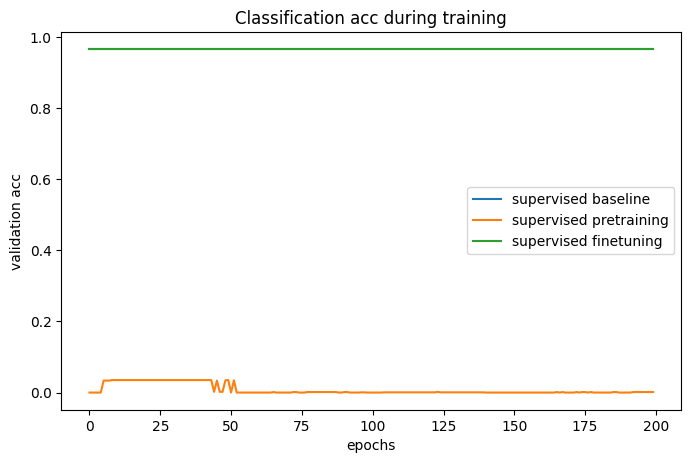

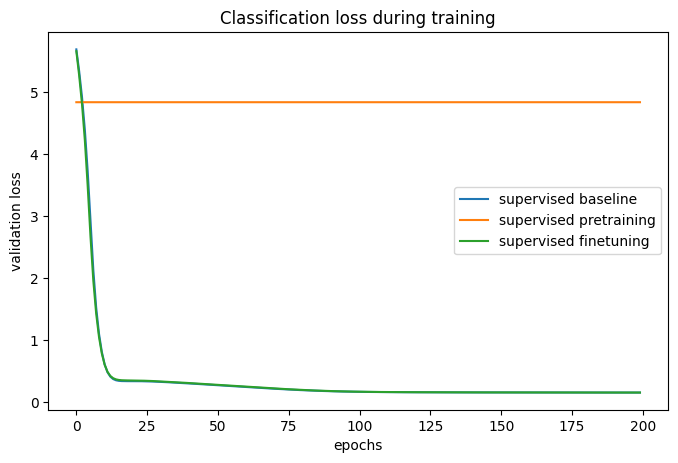

In [109]:
# The classification accuracies of the baseline and the pretraining + finetuning process:

def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc","loss"], ["acc","loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(baseline_history.history[f"val_{metric_key}"], label="supervised baseline",)
        plt.plot(pretraining_history.history[f"val_{metric_key}"],label="supervised pretraining",)
        plt.plot(finetuning_history.history[f"val_{metric_key}"],label="supervised finetuning",)
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")

plot_training_curves(pretraining_history, finetuning_history, baseline_history)

##Open ML benchmarking

In [110]:
datasets = openml.datasets.list_datasets(tag='OpenML-CC18')
# datasets

In [111]:
results = pd.DataFrame(datasets)
results

,3,6,11,12,14,15,16,18,22,23,...,40975,40978,40979,40982,40983,40984,40994,40996,41027,375
did,3,6,11,12,14,15,16,18,22,23,...,40975,40978,40979,40982,40983,40984,40994,40996,41027,375
name,kr-vs-kp,letter,balance-scale,mfeat-factors,mfeat-fourier,breast-w,mfeat-karhunen,mfeat-morphological,mfeat-zernike,cmc,...,car,Internet-Advertisements,mfeat-pixel,steel-plates-fault,wilt,segment,climate-model-simulation-crashes,Fashion-MNIST,jungle_chess_2pcs_raw_endgame_complete,JapaneseVowels
version,1,1,1,1,1,1,1,1,1,1,...,3,2,3,3,2,3,4,1,1,1
uploader,1,1,1,1,1,1,1,1,1,1,...,4265,4265,4265,4265,4265,4265,4265,2506,1,2
status,active,active,active,active,active,active,active,active,active,active,...,active,active,active,active,active,active,active,active,active,active
format,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,...,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,ARFF,arff,ARFF
MajorityClassSize,1669,813,288,200,200,458,200,200,200,629,...,1210,2820,200,673,4578,330,494,7000,23062,1614
MaxNominalAttDistinctValues,3,26,3,10,10,2,10,10,10,4,...,4,2,10,7,2,7,2,10,3,9
MinorityClassSize,1527,734,49,200,200,241,200,200,200,333,...,65,459,200,55,261,330,46,7000,4335,782
NumberOfClasses,2,26,3,10,10,2,10,10,10,3,...,4,2,10,7,2,7,2,10,3,9


In [112]:
nth_row = 1
df = results.iloc[nth_row]

In [113]:
result = pd.DataFrame(df)
result

,name
3,kr-vs-kp
6,letter
11,balance-scale
12,mfeat-factors
14,mfeat-fourier
...,...
40984,segment
40994,climate-model-simulation-crashes
40996,Fashion-MNIST
41027,jungle_chess_2pcs_raw_endgame_complete


In [114]:
print(result.shape)
print(result[result['name'] == 'Fashion-MNIST'])
print(result[result['name'] == 'mnist_784'])
print(result[result['name'] == 'CIFAR_10'])

A=['Fashion-MNIST','mnist_784','CIFAR_10']

for i in A:
  # remove rows using the drop() function
  result.drop(result.index[result['name'] == i], inplace=True)
result

(73, 1)
                name
40996  Fashion-MNIST
          name
554  mnist_784
           name
40927  CIFAR_10


,name
3,kr-vs-kp
6,letter
11,balance-scale
12,mfeat-factors
14,mfeat-fourier
...,...
40983,wilt
40984,segment
40994,climate-model-simulation-crashes
41027,jungle_chess_2pcs_raw_endgame_complete


In [115]:
result

,name
3,kr-vs-kp
6,letter
11,balance-scale
12,mfeat-factors
14,mfeat-fourier
...,...
40983,wilt
40984,segment
40994,climate-model-simulation-crashes
41027,jungle_chess_2pcs_raw_endgame_complete


#Model Comparison

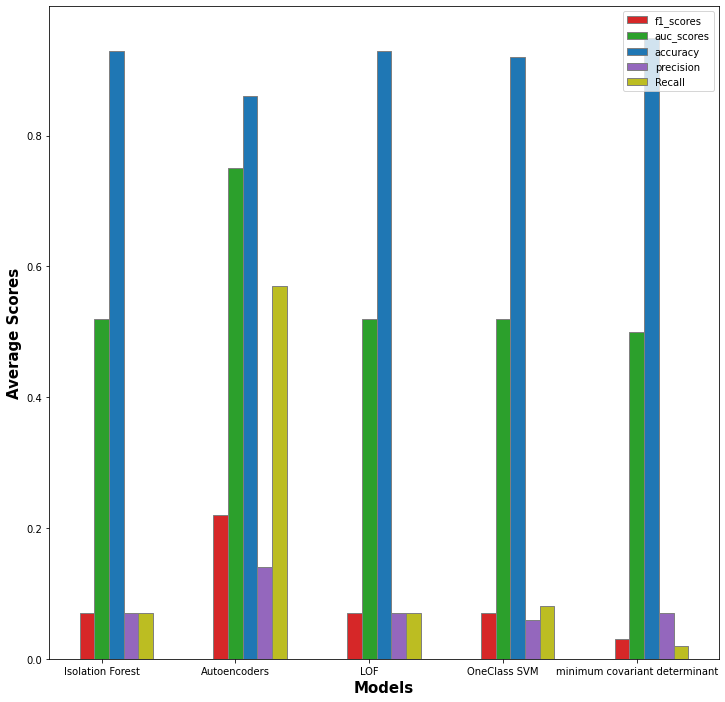

In [116]:
# set width of bar
barWidth = 0.11
fig = plt.subplots(figsize =(12, 12))
 
# set height of bar
f1_scores = [0.07, 0.22, 0.07, 0.07,0.03]
auc_scores=[0.52,0.75,0.52,0.52,0.50]
accuracy = [.93, 0.86, 0.93, 0.92,0.95]
precision = [.07, 0.14, 0.07, 0.06,0.07]
Recall = [.07, 0.57, 0.07, 0.08,0.02]
 
# Set position of bar on X axis
br1 = np.arange(len(auc_scores))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
 
# Make the plot
plt.bar(br1, f1_scores, color ='tab:red', width = barWidth, edgecolor ='grey', label ='f1_scores')
plt.bar(br2, auc_scores, color ='tab:green', width = barWidth,edgecolor ='grey', label ='auc_scores')
plt.bar(br3, accuracy, color ='tab:blue', width = barWidth,edgecolor ='grey', label ='accuracy')
plt.bar(br4, precision, color ='tab:purple', width = barWidth,edgecolor ='grey', label ='precision')
plt.bar(br5, Recall, color ='tab:olive', width = barWidth,edgecolor ='grey', label ='Recall')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Average Scores', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(auc_scores))],['Isolation Forest', 'Autoencoders', 'LOF', 'OneClass SVM','minimum covariant determinant'])
 
plt.legend()
plt.show()